In [1]:
import pandas as pd
import os
from pathlib import Path
from google.colab import drive
from sklearn.model_selection import StratifiedGroupKFold
import re
import matplotlib.pyplot as plt
import seaborn as sns

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
output_dir = Path("/content/drive/MyDrive/DMS/data/splits/12frame_windows")
train_df = pd.read_csv(output_dir / "final_train.csv")
val_df = pd.read_csv(output_dir / "final_val.csv")
test_df = pd.read_csv(output_dir / "final_test.csv")

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

<ipython-input-2-3515821212>:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(output_dir / "final_train.csv")


(94668, 14)
(16692, 14)
(27408, 14)


In [3]:
train_df.head()

,frame_path,label,camera,clip_id,frame_no,dataset,groups_12,mar,ear,yaw,pitch,phone_detected,seven_group,subject_id
0,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,0,DMD,0,0.097440,0.123009,-0.747302,0.109527,0,DMD_normal,NaN
1,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,1,DMD,0,0.158535,0.142181,-1.102433,0.204548,0,DMD_normal,NaN
2,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,2,DMD,0,0.059623,0.145776,-0.834969,-0.191205,0,DMD_normal,NaN
3,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,3,DMD,0,0.143732,0.175720,-1.127011,0.237445,0,DMD_normal,NaN
4,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,4,DMD,0,0.245684,0.189049,-2.031260,-0.091060,0,DMD_normal,NaN


In [4]:
train_df['clip_id'].iloc[0]

'gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0.avi'

In [5]:
# person_id 생성
def extract_person_id(row):
    clip = row["clip_id"]
    dataset = row["dataset"]
    if dataset == "DMD":
        return clip.split("(")[0]  # gE-27
    elif dataset == "yawDD":
        return clip.split("-")[0] + "_" + str(row["camera"])  # 9_Mirror
    else:
        return "unknown"

In [6]:
df=train_df.copy()
df["person_id"] = df.apply(extract_person_id, axis=1)
df

,frame_path,label,camera,clip_id,frame_no,dataset,groups_12,mar,ear,yaw,pitch,phone_detected,seven_group,subject_id,person_id
0,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,0,DMD,0,0.097440,0.123009,-0.747302,0.109527,0,DMD_normal,NaN,gE-27
1,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,1,DMD,0,0.158535,0.142181,-1.102433,0.204548,0,DMD_normal,NaN,gE-27
2,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,2,DMD,0,0.059623,0.145776,-0.834969,-0.191205,0,DMD_normal,NaN,gE-27
3,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,3,DMD,0,0.143732,0.175720,-1.127011,0.237445,0,DMD_normal,NaN,gE-27
4,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,4,DMD,0,0.245684,0.189049,-2.031260,-0.091060,0,DMD_normal,NaN,gE-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94663,/content/drive/MyDrive/DMS/data/processed/yawD...,yawn,dash,9-MaleNoGlasses-clip-1,31,yawDD,2,0.087486,0.028847,-0.082693,-0.008116,0,yawDD_yawn_dash,NaN,9_dash
94664,/content/drive/MyDrive/DMS/data/processed/yawD...,yawn,dash,9-MaleNoGlasses-clip-1,32,yawDD,2,0.061102,0.043209,0.015866,0.025821,0,yawDD_yawn_dash,NaN,9_dash
94665,/content/drive/MyDrive/DMS/data/processed/yawD...,yawn,dash,9-MaleNoGlasses-clip-1,33,yawDD,2,0.048925,0.048462,-0.012635,-0.124108,0,yawDD_yawn_dash,NaN,9_dash
94666,/content/drive/MyDrive/DMS/data/processed/yawD...,yawn,dash,9-MaleNoGlasses-clip-1,34,yawDD,2,0.002024,0.046302,0.010639,-0.077072,0,yawDD_yawn_dash,NaN,9_dash


In [7]:
df=train_df.copy()
df["person_id"] = df.apply(extract_person_id, axis=1)

# StratifiedGroupKFold 설정
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# 폴드 할당
df["fold"] = -1
for fold, (_, val_idx) in enumerate(sgkf.split(df, df["seven_group"], groups=df["person_id"])):
    df.loc[val_idx, "fold"] = fold

# 폴드별 분포 확인용 테이블
fold_summary = df.groupby("fold")["seven_group"].value_counts().unstack().fillna(0).astype(int)
fold_summary

seven_group,DMD_normal,DMD_phonecall,DMD_text,DMD_yawn,yawDD_normal_mirror,yawDD_yawn_dash,yawDD_yawn_mirror
fold,,,,,,,
0,19416,6336,3096,0,396,0,852
1,1716,384,204,72,636,132,732
2,12012,4908,1932,72,384,444,468
3,15840,4668,1656,72,300,84,492
4,9360,4800,1812,96,600,180,516


In [8]:
df.groupby('seven_group')['person_id'].value_counts()

seven_group        person_id
DMD_normal         gF-24        5496
                   gF-22        5328
                   gZ-32        5088
                   gZ-35        5076
                   gF-25        4692
                                ... 
yawDD_yawn_mirror  26_mirror      72
                   29_mirror      72
                   35_mirror      72
                   13_mirror      60
                   14_mirror      48
Name: count, Length: 117, dtype: int64

In [9]:
dmd = df[df['dataset']=='DMD']

In [10]:
yawdd = df[df['dataset']=='yawDD']

## yawDD gender, sunglasses 유무 parsing

In [11]:
def parse_clip_id(clip_id: str):
    """
    다양한 형태의 clip_id 파싱:
    - 성별, 안경 종류, 수염(옵션), 행동(옵션), clip 번호 추출
    - Glasses와 수염 타입이 붙어있을 경우 분리 처리
    """
    clip_id = clip_id.replace(".avi", "")
    # 행동 포함 버전
    pattern = r"(\d+)-(Male|Female)(NoGlasses|SunGlasses|Prescription|Glasses)(Beard|moustache)?-([\w&]+)-clip-(\d+)"
    match = re.match(pattern, clip_id)
    if match:
        return {
            "clip_id": clip_id,
            "participant_number": int(match.group(1)),
            "gender": match.group(2),
            "glasses": match.group(3),
            "facial_hair": match.group(4) or "None",  # 없으면 None으로 처리
            "action": match.group(5),
            "clip_no": int(match.group(6)),
            "group_id": f"{match.group(1)}-{match.group(2)}"
        }


    # 행동 없는 경우
    pattern_no_action = r"(\d+)-(Male|Female)(NoGlasses|SunGlasses|Prescription|Glasses)(Beard|moustache)?-clip-(\d+)"
    match = re.match(pattern_no_action, clip_id)
    if match:
        return {
            "clip_id": clip_id,
            "participant_number": int(match.group(1)),
            "gender": match.group(2),
            "glasses": match.group(3),
            "facial_hair": match.group(4) or "None",
            "action": None,
            "clip_no": int(match.group(5)),
            "group_id": f"{match.group(1)}-{match.group(2)}"
        }

    print(clip_id)
    return None  # 포맷이 맞지 않으면 None 반환

In [12]:
clip_ids = yawdd['clip_id']
parsed_list = [parse_clip_id(cid) for cid in clip_ids]
yawdd_parsed = pd.DataFrame(parsed_list)
yawdd_parsed

,clip_id,participant_number,gender,glasses,facial_hair,action,clip_no,group_id
0,1-FemaleNoGlasses-Yawning-clip-1,1,Female,NoGlasses,None,Yawning,1,1-Female
1,1-FemaleNoGlasses-Yawning-clip-1,1,Female,NoGlasses,None,Yawning,1,1-Female
2,1-FemaleNoGlasses-Yawning-clip-1,1,Female,NoGlasses,None,Yawning,1,1-Female
3,1-FemaleNoGlasses-Yawning-clip-1,1,Female,NoGlasses,None,Yawning,1,1-Female
4,1-FemaleNoGlasses-Yawning-clip-1,1,Female,NoGlasses,None,Yawning,1,1-Female
...,...,...,...,...,...,...,...,...
6211,9-MaleNoGlasses-clip-1,9,Male,NoGlasses,None,None,1,9-Male
6212,9-MaleNoGlasses-clip-1,9,Male,NoGlasses,None,None,1,9-Male
6213,9-MaleNoGlasses-clip-1,9,Male,NoGlasses,None,None,1,9-Male
6214,9-MaleNoGlasses-clip-1,9,Male,NoGlasses,None,None,1,9-Male


In [13]:
yawdd=yawdd.reset_index(drop=True)
yawdd = pd.concat([yawdd, yawdd_parsed], axis=1)

In [14]:
yawdd['camera'].unique()

array(['mirror', 'dash'], dtype=object)

In [15]:
yawdd['facial_hair'].unique()

array(['None', 'moustache', 'Beard'], dtype=object)

In [16]:
yawdd[yawdd['facial_hair']=='Beard'].iloc[:,4].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [17]:
yawdd[(yawdd['person_id'] == '23_mirror') & (yawdd['gender'] == 'Male')].iloc[:,4].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [18]:
yawdd

,frame_path,label,camera,clip_id,frame_no,dataset,groups_12,mar,ear,yaw,...,person_id,fold,clip_id,participant_number,gender,glasses,facial_hair,action,clip_no,group_id
0,/content/drive/MyDrive/DMS/data/processed/yawD...,normal,mirror,1-FemaleNoGlasses-Yawning-clip-1,0,yawDD,0,0.012913,0.161395,-0.740891,...,1_mirror,1,1-FemaleNoGlasses-Yawning-clip-1,1,Female,NoGlasses,None,Yawning,1,1-Female
1,/content/drive/MyDrive/DMS/data/processed/yawD...,normal,mirror,1-FemaleNoGlasses-Yawning-clip-1,1,yawDD,0,0.020873,0.152588,-0.591495,...,1_mirror,1,1-FemaleNoGlasses-Yawning-clip-1,1,Female,NoGlasses,None,Yawning,1,1-Female
2,/content/drive/MyDrive/DMS/data/processed/yawD...,normal,mirror,1-FemaleNoGlasses-Yawning-clip-1,2,yawDD,0,0.071455,0.159343,-0.645483,...,1_mirror,1,1-FemaleNoGlasses-Yawning-clip-1,1,Female,NoGlasses,None,Yawning,1,1-Female
3,/content/drive/MyDrive/DMS/data/processed/yawD...,normal,mirror,1-FemaleNoGlasses-Yawning-clip-1,3,yawDD,0,0.102460,0.162376,-0.673177,...,1_mirror,1,1-FemaleNoGlasses-Yawning-clip-1,1,Female,NoGlasses,None,Yawning,1,1-Female
4,/content/drive/MyDrive/DMS/data/processed/yawD...,normal,mirror,1-FemaleNoGlasses-Yawning-clip-1,4,yawDD,0,0.202449,0.164114,-0.689567,...,1_mirror,1,1-FemaleNoGlasses-Yawning-clip-1,1,Female,NoGlasses,None,Yawning,1,1-Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,/content/drive/MyDrive/DMS/data/processed/yawD...,yawn,dash,9-MaleNoGlasses-clip-1,31,yawDD,2,0.087486,0.028847,-0.082693,...,9_dash,2,9-MaleNoGlasses-clip-1,9,Male,NoGlasses,None,None,1,9-Male
6212,/content/drive/MyDrive/DMS/data/processed/yawD...,yawn,dash,9-MaleNoGlasses-clip-1,32,yawDD,2,0.061102,0.043209,0.015866,...,9_dash,2,9-MaleNoGlasses-clip-1,9,Male,NoGlasses,None,None,1,9-Male
6213,/content/drive/MyDrive/DMS/data/processed/yawD...,yawn,dash,9-MaleNoGlasses-clip-1,33,yawDD,2,0.048925,0.048462,-0.012635,...,9_dash,2,9-MaleNoGlasses-clip-1,9,Male,NoGlasses,None,None,1,9-Male
6214,/content/drive/MyDrive/DMS/data/processed/yawD...,yawn,dash,9-MaleNoGlasses-clip-1,34,yawDD,2,0.002024,0.046302,0.010639,...,9_dash,2,9-MaleNoGlasses-clip-1,9,Male,NoGlasses,None,None,1,9-Male


In [19]:
yawdd.groupby(['camera', 'participant_number', 'gender']).count()

frame_path  label  clip_id  frame_no  \
camera participant_number gender                                         
dash   2                  Female          48     48       48        48   
                          Male            72     72       72        72   
       3                  Female          96     96       96        96   
                          Male            48     48       48        48   
       4                  Female          12     12       12        12   
...                                      ...    ...      ...       ...   
mirror 33                 Male           120    120      120       120   
       34                 Female          96     96       96        96   
                          Male            72     72       72        72   
       35                 Female          72     72       72        72   
                          Male            84     84       84        84   

                                  dataset  groups_12  mar  ear  yaw  pitch  \
camera participant_number gender                                             
dash   2                  Female       48         48   48   48   48     48   
                          Male         72         72   72   72   72     72   
       3                  Female       96         96   96   96   96     96   
                          Male         48         48   48   48   48     48   
       4                  Female       12         12   12   12   12     12   
...                                   ...        ...  ...  ...  ...    ...   
mirror 33                 Male        120        120  120  120  120    120   
       34                 Female       96         96   96   96   96     96   
                          Male         72         72   72   72   72     72   
       35                 Female       72         72   72   72   72     72   
                          Male         84         84   84   84   84     84   

                                  ...  seven_group  subject_id  person_id  \
camera participant_number gender  ...                                       
dash   2                  Female  ...           48           0         48   
                          Male    ...           72           0         72   
       3                  Female  ...           96           0         96   
                          Male    ...           48           0         48   
       4                  Female  ...           12           0         12   
...                               ...          ...         ...        ...   
mirror 33                 Male    ...          120           0        120   
       34                 Female  ...           96           0         96   
                          Male    ...           72           0         72   
       35                 Female  ...           72           0         72   
                          Male    ...           84           0         84   

                                  fold  clip_id  glasses  facial_hair  action  \
camera participant_number gender                                                
dash   2                  Female    48       48       48           48       0   
                          Male      72       72       72           72       0   
       3                  Female    96       96       96           96       0   
                          Male      48       48       48           48       0   
       4                  Female    12       12       12           12       0   
...                                ...      ...      ...          ...     ...   
mirror 33                 Male     120      120      120          120     120   
       34                 Female    96       96       96           96      96   
                          Male      72       72       72           72      72   
       35                 Female    72       72       72           72      72   
                          Male      84       84       84           84      84   



In [20]:
yawdd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6216 entries, 0 to 6215
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   frame_path          6216 non-null   object 
 1   label               6216 non-null   object 
 2   camera              6216 non-null   object 
 3   clip_id             6216 non-null   object 
 4   frame_no            6216 non-null   int64  
 5   dataset             6216 non-null   object 
 6   groups_12           6216 non-null   int64  
 7   mar                 6216 non-null   float64
 8   ear                 6216 non-null   float64
 9   yaw                 6216 non-null   float64
 10  pitch               6216 non-null   float64
 11  phone_detected      6216 non-null   int64  
 12  seven_group         6216 non-null   object 
 13  subject_id          0 non-null      object 
 14  person_id           6216 non-null   object 
 15  fold                6216 non-null   int64  
 16  clip_i

In [21]:
yawdd["person_id"] = (
    yawdd["camera"] + "_" + yawdd["participant_number"].astype(str) + "_" +yawdd["gender"]
)

In [23]:
cols = ['frame_path', 'label', 'camera', 'clip_id', 'frame_no',
       'dataset', 'groups_12', 'mar', 'ear', 'yaw', 'pitch', 'phone_detected',
       'seven_group', 'person_id']
dmd = dmd[cols]
yawdd = yawdd[cols]

In [24]:
print(dmd.columns.duplicated().any())
print(yawdd.columns.duplicated().any())


False
True


In [25]:
yawdd = yawdd.loc[:, ~yawdd.columns.duplicated()]

In [26]:
print(dmd.shape)
print(yawdd.shape)

(88452, 14)
(6216, 14)


In [27]:
combined = pd.concat([dmd, yawdd], axis=0, ignore_index=True)
combined.head()

,frame_path,label,camera,clip_id,frame_no,dataset,groups_12,mar,ear,yaw,pitch,phone_detected,seven_group,person_id
0,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,0,DMD,0,0.097440,0.123009,-0.747302,0.109527,0,DMD_normal,gE-27
1,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,1,DMD,0,0.158535,0.142181,-1.102433,0.204548,0,DMD_normal,gE-27
2,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,2,DMD,0,0.059623,0.145776,-0.834969,-0.191205,0,DMD_normal,gE-27
3,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,3,DMD,0,0.143732,0.175720,-1.127011,0.237445,0,DMD_normal,gE-27
4,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,4,DMD,0,0.245684,0.189049,-2.031260,-0.091060,0,DMD_normal,gE-27


In [28]:
df=combined.copy()

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=5) #4,22, 37
df["fold"] = -1
for fold, (_, val_idx) in enumerate(sgkf.split(df, df["seven_group"], groups=df["person_id"])):
    df.loc[val_idx, "fold"] = fold

# 폴드별 분포 확인
fold_summary = df.groupby("fold")["seven_group"].value_counts().unstack().fillna(0).astype(int)
fold_summary

seven_group,DMD_normal,DMD_phonecall,DMD_text,DMD_yawn,yawDD_normal_mirror,yawDD_yawn_dash,yawDD_yawn_mirror
fold,,,,,,,
0,12216,4704,1956,72,648,120,720
1,11376,3216,1392,0,492,156,696
2,8352,2616,1128,144,252,192,588
3,13728,5976,2340,48,372,132,564
4,12672,4584,1884,48,552,240,492


In [29]:
df.groupby('fold')['frame_path'].count()

,frame_path
fold,
0,20436
1,17328
2,13272
3,23160
4,20472


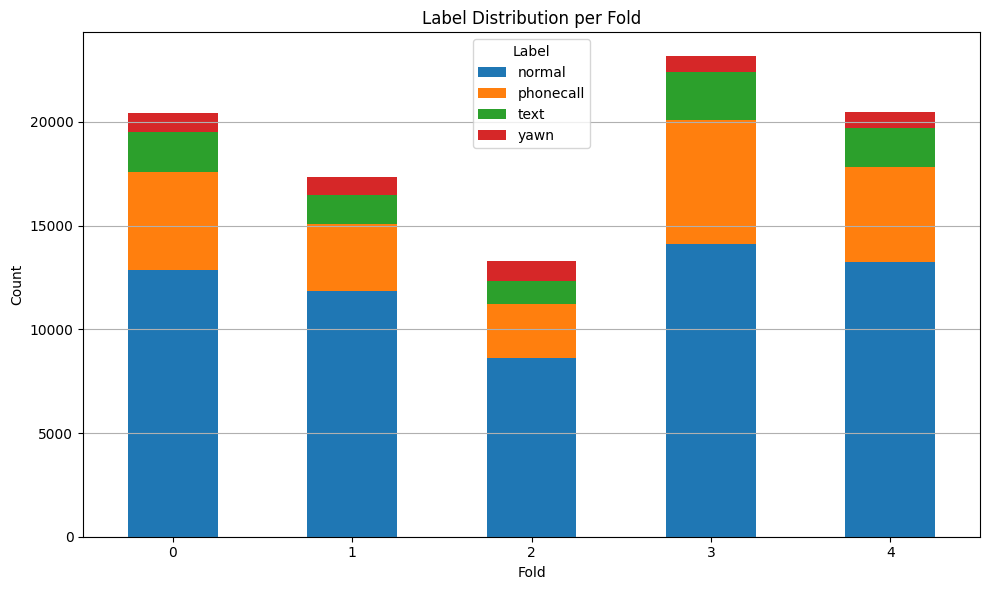

In [30]:
grouped = df.groupby(['fold', 'label'])['label'].count().unstack(fill_value=0)

# 시각화
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Label Distribution per Fold")
plt.xlabel("Fold")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Label")
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

In [31]:
df.groupby(['fold', 'label']).size().unstack().apply(lambda x: x / x.sum(), axis=1)

label,normal,phonecall,text,yawn
fold,,,,
0,0.629477,0.230182,0.095713,0.044627
1,0.684903,0.185596,0.080332,0.049169
2,0.648282,0.197107,0.084991,0.069620
3,0.608808,0.258031,0.101036,0.032124
4,0.645955,0.223916,0.092028,0.038101


In [32]:
df.clip_id.iloc[-1]

'9-MaleNoGlasses-clip-1'

In [33]:
df.to_csv(output_dir / "final_train_kfold.csv", index=False)

In [34]:
val_df = val_df.drop('Unnamed: 0', axis=1)
test_df = test_df.drop('Unnamed: 0', axis=1)

KeyError: "['Unnamed: 0'] not found in axis"

In [ ]:
val_df.to_csv(output_dir / "final_val.csv", index=False)
test_df.to_csv(output_dir / "final_test.csv", index=False)

In [35]:
df

,frame_path,label,camera,clip_id,frame_no,dataset,groups_12,mar,ear,yaw,pitch,phone_detected,seven_group,person_id,fold
0,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,0,DMD,0,0.097440,0.123009,-0.747302,0.109527,0,DMD_normal,gE-27,2
1,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,1,DMD,0,0.158535,0.142181,-1.102433,0.204548,0,DMD_normal,gE-27,2
2,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,2,DMD,0,0.059623,0.145776,-0.834969,-0.191205,0,DMD_normal,gE-27,2
3,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,3,DMD,0,0.143732,0.175720,-1.127011,0.237445,0,DMD_normal,gE-27,2
4,/content/drive/MyDrive/DMS/data/processed/dmd_...,normal,NaN,gE-27(File17)_s1_face_2019-03-07-13;14;28_27_0...,4,DMD,0,0.245684,0.189049,-2.031260,-0.091060,0,DMD_normal,gE-27,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94663,/content/drive/MyDrive/DMS/data/processed/yawD...,yawn,dash,9-MaleNoGlasses-clip-1,31,yawDD,2,0.087486,0.028847,-0.082693,-0.008116,0,yawDD_yawn_dash,dash_9_Male,3
94664,/content/drive/MyDrive/DMS/data/processed/yawD...,yawn,dash,9-MaleNoGlasses-clip-1,32,yawDD,2,0.061102,0.043209,0.015866,0.025821,0,yawDD_yawn_dash,dash_9_Male,3
94665,/content/drive/MyDrive/DMS/data/processed/yawD...,yawn,dash,9-MaleNoGlasses-clip-1,33,yawDD,2,0.048925,0.048462,-0.012635,-0.124108,0,yawDD_yawn_dash,dash_9_Male,3
94666,/content/drive/MyDrive/DMS/data/processed/yawD...,yawn,dash,9-MaleNoGlasses-clip-1,34,yawDD,2,0.002024,0.046302,0.010639,-0.077072,0,yawDD_yawn_dash,dash_9_Male,3


In [36]:
df.groupby(['fold', 'label'])['person_id'].nunique().unstack()

label,normal,phonecall,text,yawn
fold,,,,
0,14,3,3,17
1,13,3,3,15
2,10,2,2,17
3,13,4,4,15
4,12,3,3,15


In [ ]:
df.groupby(['person_id'])['frame_path'].nunique()

,frame_path
person_id,
dash_15_Male,30
dash_16_Male,24
dash_2_Female,36
dash_2_Male,72
dash_3_Female,108
...,...
mirror_34_Male,72
mirror_35_Female,78
mirror_35_Male,71


In [ ]:
count_table = df.groupby(['fold', 'label', 'person_id'])['frame_path'].count()
pivoted = count_table.unstack(level=['fold', 'label'], fill_value=0)
pivoted

fold                  0                          1                          2  \
label            normal phonecall text yawn normal phonecall text yawn normal   
person_id                                                                       
dash_15_Male          0         0    0    0      0         0    0    0      0   
dash_16_Male          0         0    0    0      0         0    0    0      0   
dash_2_Female         0         0    0    0      0         0    0    0      0   
dash_2_Male           0         0    0    0      0         0    0    0      0   
dash_3_Female         0         0    0    0      0         0    0    0      0   
...                 ...       ...  ...  ...    ...       ...  ...  ...    ...   
mirror_34_Male        0         0    0    0      0         0    0    0      0   
mirror_35_Female      0         0    0    0      0         0    0    0      0   
mirror_35_Male        0         0    0    0      0         0    0    0      0   
mirror_3_Female      24         0    0   36      0         0    0    0      0   
mirror_3_Male         0         0    0    0      0         0    0    0     72   

fold                                      3                          4  \
label            phonecall text yawn normal phonecall text yawn normal   
person_id                                                                
dash_15_Male             0    0    0      0         0    0   30      0   
dash_16_Male             0    0   24      0         0    0    0      0   
dash_2_Female            0    0    0      0         0    0    0      0   
dash_2_Male              0    0   72      0         0    0    0      0   
dash_3_Female            0    0  108      0         0    0    0      0   
...                    ...  ...  ...    ...       ...  ...  ...    ...   
mirror_34_Male           0    0    0     24         0    0   48      0   
mirror_35_Female         0    0    0      0         0    0    0     24   
mirror_35_Male           0    0    0     48         0    0   24      0   
mirror_3_Female          0    0    0      0         0    0    0      0   
mirror_3_Male            0    0   66      0         0    0    0      0   

fold                                  
label            phonecall text yawn  
person_id                             
dash_15_Male             0    0    0  
dash_16_Male             0    0    0  
dash_2_Female            0    0   36  
dash_2_Male              0    0    0  
dash_3_Female            0    0    0  
...                    ...  ...  ...  
mirror_34_Male           0    0    0  
mirror_35_Female         0    0   54  
mirror_35_Male           0    0    0  
mirror_3_Female          0    0    0  
mirror_3_Male            0    0    0  

[88 rows x 20 columns]

In [ ]:
yawdd = df[df['dataset']=='yawDD'].reset_index(drop=True)
merge_df = pd.concat([yawdd, yawdd_parsed], axis=1)

In [ ]:
merge_df.groupby(['fold', 'glasses', 'facial_hair'])['frame_path'].count()

fold  glasses     facial_hair
0     Glasses     None           426
      NoGlasses   None           564
      SunGlasses  None           210
1     Glasses     Beard           96
                  None           486
                  moustache      132
      NoGlasses   None           546
2     Glasses     None           264
      NoGlasses   None           422
      SunGlasses  None            60
3     Glasses     None           348
      NoGlasses   None           792
      SunGlasses  None            30
4     Glasses     None           486
                  moustache       78
      NoGlasses   None           504
      SunGlasses  None           168
Name: frame_path, dtype: int64

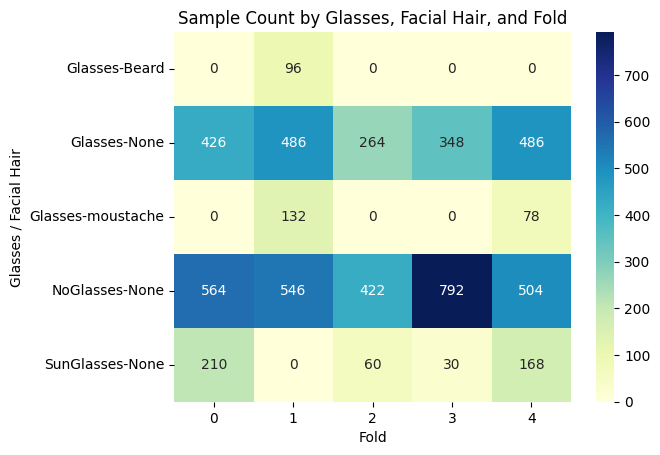

In [ ]:
pivot = merge_df.groupby(['glasses', 'facial_hair', 'fold']).size().unstack(fill_value=0)
sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Sample Count by Glasses, Facial Hair, and Fold")
plt.ylabel("Glasses / Facial Hair")
plt.xlabel("Fold")
plt.show()
